In [1]:
import pandas as pd
import numpy as np
import cx_Oracle
import os
import json
import datetime
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings(action="ignore")
from selenium import webdriver
from selenium.webdriver.support.ui import Select
from selenium.webdriver.common.by import By
import bs4
import requests
import time
import math
import random
from shapely.geometry import Point, Polygon
import time as timesys
from pyproj import Geod
from haversine import haversine
pd.set_option('display.max_columns', None)

In [2]:
voyage_list = []
waiting_list = []

In [3]:
cf_port_mis_df = pd.read_csv("voy_path/OOCL_NEW_YORK_portmis.csv")
cf_port_mis_df

,voyage_name,port_in_time,port_out_time,next_port,previous_port
0,VRJS2_2022_1,2022-09-21 06:04:00,2022-09-21 16:38:00,KAOHSIUNG,TIANJIN XINGANG PT
1,VRJS2_2022_2,2022-11-11 14:10:00,2022-11-12 03:08:00,SHANGHAI,TIANJIN XINGANG PT
2,VRJS2_2022_3,2022-12-31 19:40:00,2023-01-01 10:52:00,SHANGHAI,TIANJIN XINGANG PT


In [4]:
tos_plan_berth = pd.read_csv("tos_plan_berth.csv")


In [5]:
# time_before = cf_port_mis_df.loc[1,"port_out_time"]
# time_before = pd.to_datetime(time_before)
time_after = cf_port_mis_df.loc[2,"port_out_time"]
time_after = pd.to_datetime(time_after)


In [6]:
tos_plan_berth["timestamp"] =pd.to_datetime(tos_plan_berth["timestamp"] )

In [7]:
# tos_plan_aka_bhum = tos_plan_berth[(tos_plan_berth["timestamp"] > time_before) & (tos_plan_berth["timestamp"] < time_after )]
tos_plan_oony = tos_plan_berth[tos_plan_berth["timestamp"] < time_after]
tos_plan_oony.reset_index(inplace=True, drop=True)

In [8]:
tos_plan_oony

,TML_NUM,TML_CD,TML_CUD,VSL_CD,CALL_YEAR,CALL_SEQ,VOYAGE,PTNR_CODE,BERTH_NO,ALONG_SIDE,FROM_BITT,TO_BITT,ETA,ETB,ETW,ETC,ETD,ATA,ATB,ATW,ATC,ATD,YARD_OPEN,YARD_CLOSE,DIS_QTY,LOAD_QTY,UPDATE_TIME,timestamp
0,1936,PNIT,U,MRSX,2022,1,MRSX001,HLC,OT,P,58.0,70,2022-09-12 23:00:00,2022-09-14 16:00:00,NaN,NaN,2022-09-15 04:00:00,NaN,NaN,NaN,NaN,NaN,2022-09-11 16:00:00,2022-09-12 14:00:00,115,400,2022-09-11 11:38:15,2022-09-12 12:23:15.627783
1,1950,PNIT,U,MPER,2022,6,MPER006,MSC,T3,P,41.0,63,2022-09-17 15:00:00,2022-09-17 16:00:00,NaN,NaN,2022-09-19 16:00:00,NaN,NaN,NaN,NaN,NaN,2022-09-14 16:00:00,2022-09-17 06:00:00,1000,2400,2022-09-11 11:38:16,2022-09-12 12:23:15.627783
2,1953,PNIT,U,CFOS,2022,19,CFOS019,COH,OT,P,54.0,70,2022-09-16 11:00:00,2022-09-16 12:00:00,NaN,NaN,2022-09-18 03:00:00,NaN,NaN,NaN,NaN,NaN,2022-09-13 12:00:00,2022-09-16 02:00:00,1700,900,2022-09-11 11:38:17,2022-09-12 12:23:15.627783
3,1954,PNIT,U,CFOS,2022,20,CFOS020,COH,OT,P,54.0,70,2022-09-19 11:00:00,2022-09-19 12:00:00,NaN,NaN,2022-09-21 03:00:00,NaN,NaN,NaN,NaN,NaN,2022-09-16 12:00:00,2022-09-19 02:00:00,1700,900,2022-09-11 11:38:16,2022-09-12 12:23:15.627783
4,1955,PNIT,U,AKBM,2022,2,AKBM002,RCL,T1,P,1.0,19,2022-09-13 10:00:00,2022-09-13 11:00:00,NaN,NaN,2022-09-14 14:00:00,NaN,NaN,NaN,NaN,NaN,2022-09-10 14:00:00,2022-09-13 01:00:00,857,500,2022-09-12 08:19:23,2022-09-12 12:23:15.627783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1776600,2760,PNIT,U,MAEE,2023,1,MAEE001,MSC,T2,P,NaN,NaN,2023-01-11 19:00:00,2023-01-11 20:00:00,NaN,NaN,2023-01-12 20:00:00,NaN,NaN,NaN,NaN,NaN,2023-01-07 20:00:00,2023-01-11 10:00:00,800,800,2022-12-30 10:43:15,2023-01-01 10:51:49.280202
1776601,2761,PNIT,U,MAEE,2023,2,MAEE002,MSC,T2,P,NaN,NaN,2023-01-21 05:00:00,2023-01-21 06:00:00,NaN,NaN,2023-01-22 03:00:00,NaN,NaN,NaN,NaN,NaN,2023-01-17 06:00:00,2023-01-20 20:00:00,800,800,2022-12-30 10:43:16,2023-01-01 10:51:49.280202
1776602,2762,PNIT,U,MVMO,2023,1,MVMO001,MSC,T2,P,NaN,NaN,2023-01-18 19:00:00,2023-01-18 20:00:00,NaN,NaN,2023-01-19 20:00:00,NaN,NaN,NaN,NaN,NaN,2023-01-14 20:00:00,2023-01-18 10:00:00,800,800,2022-12-30 10:43:16,2023-01-01 10:51:49.280202
1776603,2763,PNIT,U,MVMO,2023,2,MVMO002,MSC,T2,P,NaN,NaN,2023-01-28 05:00:00,2023-01-28 06:00:00,NaN,NaN,2023-01-29 03:00:00,NaN,NaN,NaN,NaN,NaN,2023-01-24 06:00:00,2023-01-27 20:00:00,800,800,2022-12-30 10:43:17,2023-01-01 10:51:49.280202


In [9]:
OONW_VSL_CD = 'OONW'

In [10]:
tos_plan_oony = tos_plan_oony.query(f'VSL_CD == "{OONW_VSL_CD}"')
tos_plan_oony

,TML_NUM,TML_CD,TML_CUD,VSL_CD,CALL_YEAR,CALL_SEQ,VOYAGE,PTNR_CODE,BERTH_NO,ALONG_SIDE,FROM_BITT,TO_BITT,ETA,ETB,ETW,ETC,ETD,ATA,ATB,ATW,ATC,ATD,YARD_OPEN,YARD_CLOSE,DIS_QTY,LOAD_QTY,UPDATE_TIME,timestamp
13,1971,PNIT,U,OONW,2022,1,OONW001,OOL,OT,P,53.0,70,2022-09-16 16:00:00,2022-09-16 17:00:00,NaN,NaN,2022-09-17 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-09-13 17:00:00,2022-09-16 07:00:00,600,500,2022-09-11 11:38:16,2022-09-12 12:23:15.627783
75,1971,PNIT,U,OONW,2022,1,OONW001,OOL,OT,P,53.0,70,2022-09-16 16:00:00,2022-09-16 17:00:00,NaN,NaN,2022-09-17 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-09-13 17:00:00,2022-09-16 07:00:00,600,500,2022-09-11 11:38:16,2022-09-12 12:53:13.783001
137,1971,PNIT,U,OONW,2022,1,OONW001,OOL,OT,P,53.0,70,2022-09-16 16:00:00,2022-09-16 17:00:00,NaN,NaN,2022-09-17 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-09-13 17:00:00,2022-09-16 07:00:00,600,500,2022-09-11 11:38:16,2022-09-12 14:12:15.119636
199,1971,PNIT,U,OONW,2022,1,OONW001,OOL,OT,P,53.0,70,2022-09-16 16:00:00,2022-09-16 17:00:00,NaN,NaN,2022-09-17 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-09-13 17:00:00,2022-09-16 07:00:00,600,500,2022-09-11 11:38:16,2022-09-12 14:23:20.573514
261,1971,PNIT,U,OONW,2022,1,OONW001,OOL,OT,P,53.0,70,2022-09-16 16:00:00,2022-09-16 17:00:00,NaN,NaN,2022-09-17 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-09-13 17:00:00,2022-09-16 07:00:00,600,500,2022-09-11 11:38:16,2022-09-12 14:59:48.029910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1762597,2293,PNIT,U,OONW,2022,3,OONW003,OOL,T1,P,2.0,19.0,2022-12-31 19:00:00,2022-12-31 20:00:00,NaN,NaN,2023-01-01 13:00:00,NaN,2022-12-31 19:50:00,NaN,NaN,NaN,2022-12-27 18:00:00,2022-12-31 08:00:00,1303,262,2022-12-31 19:53:29,2022-12-31 23:35:05.603813
1762705,2293,PNIT,U,OONW,2022,3,OONW003,OOL,T1,P,2.0,19.0,2022-12-31 19:00:00,2022-12-31 20:00:00,NaN,NaN,2023-01-01 13:00:00,NaN,2022-12-31 19:50:00,NaN,NaN,NaN,2022-12-27 18:00:00,2022-12-31 08:00:00,1303,262,2022-12-31 19:53:29,2022-12-31 23:40:06.135909
1762813,2293,PNIT,U,OONW,2022,3,OONW003,OOL,T1,P,2.0,19.0,2022-12-31 19:00:00,2022-12-31 20:00:00,NaN,NaN,2023-01-01 13:00:00,NaN,2022-12-31 19:50:00,NaN,NaN,NaN,2022-12-27 18:00:00,2022-12-31 08:00:00,1303,262,2022-12-31 19:53:29,2022-12-31 23:45:07.206779
1762921,2293,PNIT,U,OONW,2022,3,OONW003,OOL,T1,P,2.0,19.0,2022-12-31 19:00:00,2022-12-31 20:00:00,NaN,NaN,2023-01-01 13:00:00,NaN,2022-12-31 19:50:00,NaN,NaN,NaN,2022-12-27 18:00:00,2022-12-31 08:00:00,1303,262,2022-12-31 19:53:29,2022-12-31 23:50:07.942396


In [11]:
set(tos_plan_oony.sort_values(by="VOYAGE")['VOYAGE'].values)

{'OONW001', 'OONW002', 'OONW003'}

In [12]:
voyages = list(set(tos_plan_oony.sort_values(by="VOYAGE")['VOYAGE'].values))
for voyage in voyages:
    df = tos_plan_oony.query(f'VOYAGE == "{voyage}"')
    df.reset_index(inplace=True, drop=True)
    globals()[voyage + "_df"] = df
    display(df)

,TML_NUM,TML_CD,TML_CUD,VSL_CD,CALL_YEAR,CALL_SEQ,VOYAGE,PTNR_CODE,BERTH_NO,ALONG_SIDE,FROM_BITT,TO_BITT,ETA,ETB,ETW,ETC,ETD,ATA,ATB,ATW,ATC,ATD,YARD_OPEN,YARD_CLOSE,DIS_QTY,LOAD_QTY,UPDATE_TIME,timestamp
0,2241,PNIT,U,OONW,2022,2,OONW002,OOL,T2,P,NaN,NaN,2022-11-11 16:00:00,2022-11-11 17:00:00,NaN,NaN,2022-11-12 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-11-08 17:00:00,2022-11-11 07:00:00,600,500,2022-10-25 13:20:57,2022-10-29 00:01:26.679224
1,2241,PNIT,U,OONW,2022,2,OONW002,OOL,T2,P,NaN,NaN,2022-11-11 16:00:00,2022-11-11 17:00:00,NaN,NaN,2022-11-12 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-11-08 17:00:00,2022-11-11 07:00:00,600,500,2022-10-25 13:20:57,2022-10-29 00:06:29.617690
2,2241,PNIT,U,OONW,2022,2,OONW002,OOL,T2,P,NaN,NaN,2022-11-11 16:00:00,2022-11-11 17:00:00,NaN,NaN,2022-11-12 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-11-08 17:00:00,2022-11-11 07:00:00,600,500,2022-10-25 13:20:57,2022-10-29 00:11:32.533846
3,2241,PNIT,U,OONW,2022,2,OONW002,OOL,T2,P,NaN,NaN,2022-11-11 16:00:00,2022-11-11 17:00:00,NaN,NaN,2022-11-12 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-11-08 17:00:00,2022-11-11 07:00:00,600,500,2022-10-25 13:20:57,2022-10-29 00:16:35.487989
4,2241,PNIT,U,OONW,2022,2,OONW002,OOL,T2,P,NaN,NaN,2022-11-11 16:00:00,2022-11-11 17:00:00,NaN,NaN,2022-11-12 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-11-08 17:00:00,2022-11-11 07:00:00,600,500,2022-10-25 13:20:57,2022-10-29 00:21:38.107604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3585,2241,PNIT,U,OONW,2022,2,OONW002,OOL,T1,P,3.0,20.0,2022-11-11 13:00:00,2022-11-11 14:00:00,NaN,NaN,2022-11-12 04:00:00,NaN,2022-11-11 14:25:00,NaN,NaN,NaN,2022-11-08 14:00:00,2022-11-11 04:00:00,927,295,2022-11-11 14:26:35,2022-11-11 23:35:20.726184
3586,2241,PNIT,U,OONW,2022,2,OONW002,OOL,T1,P,3.0,20.0,2022-11-11 13:00:00,2022-11-11 14:00:00,NaN,NaN,2022-11-12 04:00:00,NaN,2022-11-11 14:25:00,NaN,NaN,NaN,2022-11-08 14:00:00,2022-11-11 04:00:00,927,295,2022-11-11 14:26:35,2022-11-11 23:40:23.524000
3587,2241,PNIT,U,OONW,2022,2,OONW002,OOL,T1,P,3.0,20.0,2022-11-11 13:00:00,2022-11-11 14:00:00,NaN,NaN,2022-11-12 04:00:00,NaN,2022-11-11 14:25:00,NaN,NaN,NaN,2022-11-08 14:00:00,2022-11-11 04:00:00,927,295,2022-11-11 14:26:35,2022-11-11 23:45:26.643829
3588,2241,PNIT,U,OONW,2022,2,OONW002,OOL,T1,P,3.0,20.0,2022-11-11 13:00:00,2022-11-11 14:00:00,NaN,NaN,2022-11-12 03:00:00,NaN,2022-11-11 14:25:00,NaN,NaN,NaN,2022-11-08 14:00:00,2022-11-11 04:00:00,927,295,2022-11-11 23:46:49,2022-11-11 23:50:29.386219


,TML_NUM,TML_CD,TML_CUD,VSL_CD,CALL_YEAR,CALL_SEQ,VOYAGE,PTNR_CODE,BERTH_NO,ALONG_SIDE,FROM_BITT,TO_BITT,ETA,ETB,ETW,ETC,ETD,ATA,ATB,ATW,ATC,ATD,YARD_OPEN,YARD_CLOSE,DIS_QTY,LOAD_QTY,UPDATE_TIME,timestamp
0,1971,PNIT,U,OONW,2022,1,OONW001,OOL,OT,P,53.0,70,2022-09-16 16:00:00,2022-09-16 17:00:00,NaN,NaN,2022-09-17 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-09-13 17:00:00,2022-09-16 07:00:00,600,500,2022-09-11 11:38:16,2022-09-12 12:23:15.627783
1,1971,PNIT,U,OONW,2022,1,OONW001,OOL,OT,P,53.0,70,2022-09-16 16:00:00,2022-09-16 17:00:00,NaN,NaN,2022-09-17 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-09-13 17:00:00,2022-09-16 07:00:00,600,500,2022-09-11 11:38:16,2022-09-12 12:53:13.783001
2,1971,PNIT,U,OONW,2022,1,OONW001,OOL,OT,P,53.0,70,2022-09-16 16:00:00,2022-09-16 17:00:00,NaN,NaN,2022-09-17 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-09-13 17:00:00,2022-09-16 07:00:00,600,500,2022-09-11 11:38:16,2022-09-12 14:12:15.119636
3,1971,PNIT,U,OONW,2022,1,OONW001,OOL,OT,P,53.0,70,2022-09-16 16:00:00,2022-09-16 17:00:00,NaN,NaN,2022-09-17 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-09-13 17:00:00,2022-09-16 07:00:00,600,500,2022-09-11 11:38:16,2022-09-12 14:23:20.573514
4,1971,PNIT,U,OONW,2022,1,OONW001,OOL,OT,P,53.0,70,2022-09-16 16:00:00,2022-09-16 17:00:00,NaN,NaN,2022-09-17 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-09-13 17:00:00,2022-09-16 07:00:00,600,500,2022-09-11 11:38:16,2022-09-12 14:59:48.029910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,1971,PNIT,U,OONW,2022,1,OONW001,OOL,T3,P,43.0,60,2022-09-21 06:00:00,2022-09-21 06:00:00,NaN,NaN,2022-09-21 16:15:00,NaN,2022-09-21 06:20:00,2022-09-21 08:04:00,2022-09-21 16:14:00,2022-09-21 16:40:00,2022-09-18 07:00:00,2022-09-20 21:00:00,764,241,2022-09-21 17:56:21,2022-09-21 23:24:02.568455
419,1971,PNIT,U,OONW,2022,1,OONW001,OOL,T3,P,43.0,60,2022-09-21 06:00:00,2022-09-21 06:00:00,NaN,NaN,2022-09-21 16:15:00,NaN,2022-09-21 06:20:00,2022-09-21 08:04:00,2022-09-21 16:14:00,2022-09-21 16:40:00,2022-09-18 07:00:00,2022-09-20 21:00:00,764,241,2022-09-21 17:56:21,2022-09-21 23:54:04.885448
420,1971,PNIT,U,OONW,2022,1,OONW001,OOL,T3,P,43.0,60,2022-09-21 06:00:00,2022-09-21 06:00:00,NaN,NaN,2022-09-21 16:15:00,NaN,2022-09-21 06:20:00,2022-09-21 08:04:00,2022-09-21 16:14:00,2022-09-21 16:40:00,2022-09-18 06:00:00,2022-09-20 21:00:00,764,241,2022-09-22 11:18:24,2022-10-19 17:00:33.397252
421,1971,PNIT,U,OONW,2022,1,OONW001,OOL,T3,P,43.0,60,2022-09-21 06:00:00,2022-09-21 06:00:00,NaN,NaN,2022-09-21 16:15:00,NaN,2022-09-21 06:20:00,2022-09-21 08:04:00,2022-09-21 16:14:00,2022-09-21 16:40:00,2022-09-18 06:00:00,2022-09-20 21:00:00,764,241,2022-09-22 11:18:24,2022-10-19 17:01:30.995609


,TML_NUM,TML_CD,TML_CUD,VSL_CD,CALL_YEAR,CALL_SEQ,VOYAGE,PTNR_CODE,BERTH_NO,ALONG_SIDE,FROM_BITT,TO_BITT,ETA,ETB,ETW,ETC,ETD,ATA,ATB,ATW,ATC,ATD,YARD_OPEN,YARD_CLOSE,DIS_QTY,LOAD_QTY,UPDATE_TIME,timestamp
0,2293,PNIT,D,OONW,2022,3,OONW003,OOL,T2,P,NaN,NaN,2022-11-04 16:00:00,2022-11-04 17:00:00,NaN,NaN,2022-11-05 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-10-04 17:00:00,2022-11-04 07:00:00,600,500,NaN,2022-11-01 17:36:50.501338
1,2293,PNIT,D,OONW,2022,3,OONW003,OOL,T2,P,NaN,NaN,2022-11-04 16:00:00,2022-11-04 17:00:00,NaN,NaN,2022-11-05 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-10-04 17:00:00,2022-11-04 07:00:00,600,500,NaN,2022-11-01 17:41:50.815235
2,2293,PNIT,D,OONW,2022,3,OONW003,OOL,T2,P,NaN,NaN,2022-11-04 16:00:00,2022-11-04 17:00:00,NaN,NaN,2022-11-05 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-10-04 17:00:00,2022-11-04 07:00:00,600,500,NaN,2022-11-01 17:46:53.364692
3,2293,PNIT,D,OONW,2022,3,OONW003,OOL,T2,P,NaN,NaN,2022-11-04 16:00:00,2022-11-04 17:00:00,NaN,NaN,2022-11-05 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-10-04 17:00:00,2022-11-04 07:00:00,600,500,NaN,2022-11-01 17:51:56.087097
4,2293,PNIT,D,OONW,2022,3,OONW003,OOL,T2,P,NaN,NaN,2022-11-04 16:00:00,2022-11-04 17:00:00,NaN,NaN,2022-11-05 12:00:00,NaN,NaN,NaN,NaN,NaN,2022-10-04 17:00:00,2022-11-04 07:00:00,600,500,NaN,2022-11-01 17:56:59.421866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11879,2293,PNIT,U,OONW,2022,3,OONW003,OOL,T1,P,2.0,19.0,2022-12-31 19:00:00,2022-12-31 20:00:00,NaN,NaN,2023-01-01 13:00:00,NaN,2022-12-31 19:50:00,NaN,NaN,NaN,2022-12-27 18:00:00,2022-12-31 08:00:00,1303,262,2022-12-31 19:53:29,2022-12-31 23:35:05.603813
11880,2293,PNIT,U,OONW,2022,3,OONW003,OOL,T1,P,2.0,19.0,2022-12-31 19:00:00,2022-12-31 20:00:00,NaN,NaN,2023-01-01 13:00:00,NaN,2022-12-31 19:50:00,NaN,NaN,NaN,2022-12-27 18:00:00,2022-12-31 08:00:00,1303,262,2022-12-31 19:53:29,2022-12-31 23:40:06.135909
11881,2293,PNIT,U,OONW,2022,3,OONW003,OOL,T1,P,2.0,19.0,2022-12-31 19:00:00,2022-12-31 20:00:00,NaN,NaN,2023-01-01 13:00:00,NaN,2022-12-31 19:50:00,NaN,NaN,NaN,2022-12-27 18:00:00,2022-12-31 08:00:00,1303,262,2022-12-31 19:53:29,2022-12-31 23:45:07.206779
11882,2293,PNIT,U,OONW,2022,3,OONW003,OOL,T1,P,2.0,19.0,2022-12-31 19:00:00,2022-12-31 20:00:00,NaN,NaN,2023-01-01 13:00:00,NaN,2022-12-31 19:50:00,NaN,NaN,NaN,2022-12-27 18:00:00,2022-12-31 08:00:00,1303,262,2022-12-31 19:53:29,2022-12-31 23:50:07.942396


# 항차 데이터 확인

## 항차 확인

In [13]:
oocl_nw_1 = pd.read_csv("실험/230205_OOCL NEW YORK_exp_result_df_4_1_2_3_seg_90_voy_1")
oocl_nw_1

,vessel_name,mmsi,imo,CAPACITY,destination,eta,longitude,latitude,speed,heading,timestamp,time_position_data_received,time_voyage_data_received,navigation_info,remained_distance,estimated_fuel_consumption,ETA,ATA,error
0,OOCL NEW YORK,477274700,9198109.0,5770,HKG CN ZIN,9121000,118.2459,38.8466,9.7,97.0,2022-09-14 12:46:11.783705,2022-09-14 02:33:56.000000,2022-09-13 10:25:51.000000,under way using engine,1033.365335,1700.726451,2022-09-16 18:27:51.145111,2022-09-21 04:22:27.234942,4 days 09:54:36.089831
1,OOCL NEW YORK,477274700,9198109.0,5770,HKG CN ZIN,9121000,118.5881,38.8012,7.7,94.0,2022-09-14 13:46:22.415649,2022-09-14 04:24:46.000000,2022-09-13 10:25:51.000000,under way using engine,1003.951371,1756.661582,2022-09-16 18:42:08.690074,2022-09-21 04:22:27.234942,4 days 09:40:18.544868
2,OOCL NEW YORK,477274700,9198109.0,5770,HKG CN ZIN,9121000,118.6308,38.7962,7.7,93.0,2022-09-14 14:16:26.333056,2022-09-14 04:53:19.000000,2022-09-13 10:25:51.000000,under way using engine,1000.311972,1750.293552,2022-09-16 18:24:23.818008,2022-09-21 04:22:27.234942,4 days 09:58:03.416934
3,OOCL NEW YORK,477274700,9198109.0,5770,HKG CN ZIN,9121000,118.7645,38.7795,6.9,92.0,2022-09-14 14:53:58.476930,2022-09-14 05:34:24.000000,2022-09-13 10:25:51.000000,under way using engine,988.878505,1830.689186,NaN,2022-09-21 04:22:27.234942,NaN
4,OOCL NEW YORK,477274700,9198109.0,5770,KRBNP,9191201,120.2620,38.5983,9.3,90.0,2022-09-15 00:06:39.552593,2022-09-14 13:59:06.000000,2022-09-14 02:07:53.000000,under way using engine,861.791634,1424.531580,2022-09-16 21:29:16.776502,2022-09-21 04:22:27.234942,4 days 06:53:10.458440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,OOCL NEW YORK,477274700,9198109.0,5770,KRBNP,9200800,128.7517,34.5844,10.7,54.0,2022-09-21 02:22:17.302684,2022-09-20 17:22:04.000000,2022-09-20 04:07:52.000000,under way using engine,43.276999,71.469669,NaN,2022-09-21 04:22:27.234942,NaN
126,OOCL NEW YORK,477274700,9198109.0,5770,KRBNP,9200800,128.8231,34.6352,11.8,52.0,2022-09-21 02:52:19.854137,2022-09-20 17:46:35.000000,2022-09-20 04:07:52.000000,under way using engine,37.185128,62.878927,NaN,2022-09-21 04:22:27.234942,NaN
127,OOCL NEW YORK,477274700,9198109.0,5770,KRBNP,9200800,128.8711,34.7158,11.8,6.0,2022-09-21 03:22:25.762460,2022-09-20 18:16:43.000000,2022-09-20 06:19:50.000000,under way using engine,28.612241,48.382435,NaN,2022-09-21 04:22:27.234942,NaN
128,OOCL NEW YORK,477274700,9198109.0,5770,KRBNP,9200800,128.8695,34.8179,11.7,1.0,2022-09-21 03:52:24.615656,2022-09-20 18:48:25.000000,2022-09-20 06:49:53.000000,under way using engine,17.475018,29.464406,NaN,2022-09-21 04:22:27.234942,NaN


In [14]:
oocl_nw_2 = pd.read_csv("실험/230205_OOCL NEW YORK_exp_result_df_4_1_2_3_seg_90_voy_2")
oocl_nw_2

,vessel_name,mmsi,imo,CAPACITY,destination,eta,longitude,latitude,speed,heading,timestamp,time_position_data_received,time_voyage_data_received,navigation_info,remained_distance,estimated_fuel_consumption,ETA,ATA,error
0,OOCL NEW YORK,477274700,9198109.0,5770,KRBNP,11110400,117.8270,38.9647,11.5,103.0,2022-11-09 06:00:25.073144,2022-11-08 20:55:39.000000,2022-11-08 08:55:53.000000,under way using engine,1071.908021,1797.659608,2022-11-11 12:33:10.404025,2022-11-11 12:29:16.869978,0 days 00:03:53.534047
1,OOCL NEW YORK,477274700,9198109.0,5770,KRBNP,11110400,117.8956,38.9543,12.1,99.0,2022-11-09 06:15:33.878173,2022-11-08 21:11:46.000000,2022-11-08 09:14:06.000000,under way using engine,1065.958409,1819.656107,2022-11-11 12:48:19.209054,2022-11-11 12:29:16.869978,0 days 00:19:02.339076
2,OOCL NEW YORK,477274700,9198109.0,5770,KRBNP,11110400,117.9624,38.9442,14.0,99.0,2022-11-09 06:30:42.756278,2022-11-08 21:25:52.000000,2022-11-08 09:19:51.000000,under way using engine,1060.167005,1966.358246,2022-11-11 13:03:28.087159,2022-11-11 12:29:16.869978,0 days 00:34:11.217181
3,OOCL NEW YORK,477274700,9198109.0,5770,KRBNP,11110400,117.9957,38.9396,14.2,105.0,2022-11-09 06:35:45.106117,2022-11-08 21:32:43.000000,2022-11-08 09:31:52.000000,under way using engine,1057.297939,1981.927468,2022-11-11 13:08:30.436998,2022-11-11 12:29:16.869978,0 days 00:39:13.567020
4,OOCL NEW YORK,477274700,9198109.0,5770,KRBNP,11110400,118.0359,38.9330,12.7,100.0,2022-11-09 06:45:51.207053,2022-11-08 21:40:53.000000,2022-11-08 09:43:52.000000,under way using engine,1053.792393,1839.355407,2022-11-11 13:18:36.537934,2022-11-11 12:29:16.869978,0 days 00:49:19.667956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366,OOCL NEW YORK,477274700,9198109.0,5770,KRBNP,11110345,128.8939,34.8405,15.2,19.0,2022-11-11 11:53:57.692174,2022-11-11 02:53:36.000000,2022-11-11 02:43:51.000000,under way using engine,15.879774,31.509097,NaN,2022-11-11 12:29:16.869978,NaN
367,OOCL NEW YORK,477274700,9198109.0,5770,KRBNP,11110345,128.9024,34.8611,15.0,8.0,2022-11-11 11:58:59.902508,2022-11-11 02:58:47.000000,2022-11-11 02:43:51.000000,under way using engine,14.239404,27.921625,NaN,2022-11-11 12:29:16.869978,NaN
368,OOCL NEW YORK,477274700,9198109.0,5770,KRBNP,11110345,128.8836,34.9055,9.5,342.0,2022-11-11 12:14:08.220986,2022-11-11 03:11:59.000000,2022-11-11 03:13:52.000000,under way using engine,9.219392,15.199734,NaN,2022-11-11 12:29:16.869978,NaN
369,OOCL NEW YORK,477274700,9198109.0,5770,KRBNP,11110345,128.8796,34.9192,4.8,354.0,2022-11-11 12:24:14.039319,2022-11-11 03:19:32.000000,2022-11-11 03:19:50.000000,under way using engine,7.839992,18.919872,NaN,2022-11-11 12:29:16.869978,NaN


In [15]:
oocl_nw_3 = pd.read_csv("실험/230205_OOCL NEW YORK_exp_result_df_4_1_2_3_seg_90_voy_3")
oocl_nw_3

,vessel_name,mmsi,imo,CAPACITY,destination,eta,longitude,latitude,speed,heading,timestamp,time_position_data_received,time_voyage_data_received,navigation_info,remained_distance,estimated_fuel_consumption,ETA,ATA,error
0,OOCL NEW YORK,477274700,9198109.0,5770,KRBNP,12310800,117.8170,38.9665,11.8,104.0,2022-12-29 13:44:12.367784,2022-12-29 04:42:24.000000,2022-12-29 04:37:53.000000,under way using engine,1072.786744,75.585414,2022-12-31 20:16:57.698665,2022-12-31 18:24:32.781137,0 days 01:52:24.917528
1,OOCL NEW YORK,477274700,9198109.0,5770,KRBNP,12310800,117.8416,38.9625,12.9,100.0,2022-12-29 13:49:12.940123,2022-12-29 04:48:09.000000,2022-12-29 04:37:53.000000,under way using engine,1070.642228,78.514809,2022-12-31 20:21:58.271004,2022-12-31 18:24:32.781137,0 days 01:57:25.489867
2,OOCL NEW YORK,477274700,9198109.0,5770,KRBNP,12310800,117.8813,38.9556,11.7,101.0,2022-12-29 13:59:15.117322,2022-12-29 04:57:24.000000,2022-12-29 04:49:50.000000,under way using engine,1067.163725,74.972135,2022-12-31 20:32:00.448203,2022-12-31 18:24:32.781137,0 days 02:07:27.667066
3,OOCL NEW YORK,477274700,9198109.0,5770,KRBNP,12310800,117.9317,38.9483,12.5,99.0,2022-12-29 14:09:15.957091,2022-12-29 05:08:50.000000,2022-12-29 05:01:53.000000,under way using engine,1062.806687,76.688942,2022-12-31 20:42:01.287972,2022-12-31 18:24:32.781137,0 days 02:17:28.506835
4,OOCL NEW YORK,477274700,9198109.0,5770,KRBNP,12310800,117.9527,38.9452,13.6,98.0,2022-12-29 14:14:16.914741,2022-12-29 05:13:23.000000,2022-12-29 05:01:53.000000,under way using engine,1060.989098,80.349196,2022-12-31 20:47:02.245622,2022-12-31 18:24:32.781137,0 days 02:22:29.464485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,OOCL NEW YORK,477274700,9198109.0,5770,KRBNP,12310945,128.8778,34.8768,9.7,340.0,2022-12-31 17:54:28.136385,2022-12-31 08:52:01.000000,2022-12-31 08:49:51.000000,under way using engine,11.609495,0.796128,NaN,2022-12-31 18:24:32.781137,NaN
237,OOCL NEW YORK,477274700,9198109.0,5770,KRBNP,12310945,128.8751,34.8832,8.6,331.0,2022-12-31 17:59:31.699062,2022-12-31 08:54:41.000000,2022-12-31 08:49:51.000000,under way using engine,10.864597,0.760815,NaN,2022-12-31 18:24:32.781137,NaN
238,OOCL NEW YORK,477274700,9198109.0,5770,KRBNP,12310945,128.8658,34.9011,4.5,320.0,2022-12-31 18:09:30.147004,2022-12-31 09:07:51.000000,2022-12-31 09:07:53.000000,under way using engine,8.710254,0.925649,NaN,2022-12-31 18:24:32.781137,NaN
239,OOCL NEW YORK,477274700,9198109.0,5770,KRBNP,12310945,128.8539,34.9153,11.3,320.0,2022-12-31 18:19:31.696142,2022-12-31 09:15:04.000000,2022-12-31 09:13:51.000000,under way using engine,6.805617,0.473290,NaN,2022-12-31 18:24:32.781137,NaN


In [16]:
oocl_nw_1["eta"].value_counts()

9200900    67
9191201    45
9200800    14
9121000     4
Name: eta, dtype: int64

In [17]:
oocl_nw_2["eta"].value_counts()

11110200    288
11110400     38
11110330     23
11110345     18
11110430      4
Name: eta, dtype: int64

In [18]:
oocl_nw_3["eta"].value_counts()

12310800    202
12311100     15
12310945     15
12311050      9
Name: eta, dtype: int64

In [19]:
oocl_nw_1["timestamp"] =pd.to_datetime(oocl_nw_1["timestamp"])
oocl_nw_1["error"] =pd.to_timedelta(oocl_nw_1["error"])
oocl_nw_1["ETA"] =pd.to_datetime(oocl_nw_1["ETA"])
oocl_nw_1["ATA"] =pd.to_datetime(oocl_nw_1["ATA"])
oocl_nw_1["time_position_data_received"] =pd.to_datetime(oocl_nw_1["time_position_data_received"])
oocl_nw_1["time_voyage_data_received"] =pd.to_datetime(oocl_nw_1["time_voyage_data_received"])
oocl_nw_1 = oocl_nw_1.loc[oocl_nw_1[["ETA", "error"]].dropna().index]
oocl_nw_1.reset_index(inplace=True)
oocl_nw_1["eta"] = oocl_nw_1["eta"].astype(str)
oocl_nw_1["ais_eta"] = oocl_nw_1["eta"].apply(lambda x: '2022-0'+x[:1]+"-"+x[1:3]+" "+x[3:5] + ":" + x[5:7] + ":00")
oocl_nw_1["ais_eta"] =pd.to_datetime(oocl_nw_1["ais_eta"])


In [20]:
oocl_nw_2["timestamp"] =pd.to_datetime(oocl_nw_2["timestamp"])
oocl_nw_2["error"] =pd.to_timedelta(oocl_nw_2["error"])
oocl_nw_2["ETA"] =pd.to_datetime(oocl_nw_2["ETA"])
oocl_nw_2["ATA"] =pd.to_datetime(oocl_nw_2["ATA"])
oocl_nw_2["time_position_data_received"] =pd.to_datetime(oocl_nw_2["time_position_data_received"])
oocl_nw_2["time_voyage_data_received"] =pd.to_datetime(oocl_nw_2["time_voyage_data_received"])
oocl_nw_2 = oocl_nw_2.loc[oocl_nw_2[["ETA", "error"]].dropna().index]
oocl_nw_2.reset_index(inplace=True)
oocl_nw_2["eta"] = oocl_nw_2["eta"].astype(str)
oocl_nw_2["ais_eta"] = oocl_nw_2["eta"].apply(lambda x: '2022-'+x[:2]+"-"+x[2:4]+" "+x[4:6] + ":" + x[6:8] + ":00")
oocl_nw_2["ais_eta"] =pd.to_datetime(oocl_nw_2["ais_eta"])


In [21]:
oocl_nw_3["timestamp"] =pd.to_datetime(oocl_nw_3["timestamp"])
oocl_nw_3["error"] =pd.to_timedelta(oocl_nw_3["error"])
oocl_nw_3["ETA"] =pd.to_datetime(oocl_nw_3["ETA"])
oocl_nw_3["ATA"] =pd.to_datetime(oocl_nw_3["ATA"])
oocl_nw_3["time_position_data_received"] =pd.to_datetime(oocl_nw_3["time_position_data_received"])
oocl_nw_3["time_voyage_data_received"] =pd.to_datetime(oocl_nw_3["time_voyage_data_received"])
oocl_nw_3 = oocl_nw_3.loc[oocl_nw_3[["ETA", "error"]].dropna().index]
oocl_nw_3.reset_index(inplace=True)
oocl_nw_3["eta"] = oocl_nw_3["eta"].astype(str)
oocl_nw_3["ais_eta"] = oocl_nw_3["eta"].apply(lambda x: '2022-'+x[:2]+"-"+x[2:4]+" "+x[4:6] + ":" + x[6:8] + ":00")
oocl_nw_3["ais_eta"] =pd.to_datetime(oocl_nw_3["ais_eta"])


# 입항 후 대기 여부

감속하지 않는 경우, 감속하는 경우 판단. 속도를 얼마동안 감속하는지 확인

In [22]:
from matplotlib.ticker import MultipleLocator, IndexLocator, FuncFormatter
from matplotlib.dates import MonthLocator, DateFormatter
import seaborn as sns

## 1

In [23]:
df = oocl_nw_1
voy_num = 1

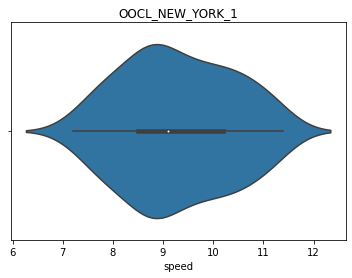

In [24]:
# use the seaborn violinplot function to visualize the distribution of the speed values
sns.violinplot(data=df, x='speed')
plt.title(f"OOCL_NEW_YORK_{voy_num}")

plt.show()

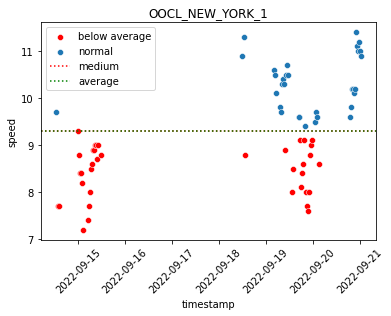

In [25]:
cosco_fos_26 = df
sns.scatterplot(
    data=cosco_fos_26[cosco_fos_26["speed"] < cosco_fos_26["speed"].mean()],
    x='timestamp',
    y='speed',
    color="red",
    label="below average")
sns.scatterplot(
    data=cosco_fos_26[cosco_fos_26["speed"] >= cosco_fos_26["speed"].mean()],
    x='timestamp',
    y='speed',
    label="normal")
plt.title(f"OOCL_NEW_YORK_{voy_num}")
plt.xticks(rotation=45)
# plt.axvline(x=cosco_fos_26["timestamp"].values[0],
#             color="pink",
#             linestyle="dashed",
#             label="dfdf")
# plt.axvline(x=cosco_fos_26["timestamp"].values[-1],
#             color="pink",
#             linestyle="dashed")
# plt.axhline(y=cosco_fos_23["speed"].mean(), linestyle="dotted")
plt.axhline(y=(cosco_fos_26["speed"].max() + cosco_fos_26["speed"].min()) / 2,
            linestyle="dotted",
            label="medium",
            color="red",
            )
plt.axhline(y=cosco_fos_26["speed"].mean(),
            linestyle="dotted",
            label="average",
            color="green",
            )
# use the seaborn violinplot function to visualize the distribution of the speed values
# sns.violinplot(data=cosco_fos_23, x='index', y='speed', inner="stick")
plt.legend()
plt.show()

## 2

In [26]:
df = oocl_nw_2
voy_num = 2

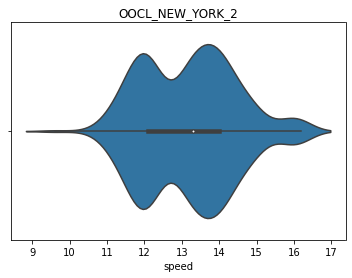

In [27]:
# use the seaborn violinplot function to visualize the distribution of the speed values
sns.violinplot(data=df, x='speed')
plt.title(f"OOCL_NEW_YORK_{voy_num}")

plt.show()

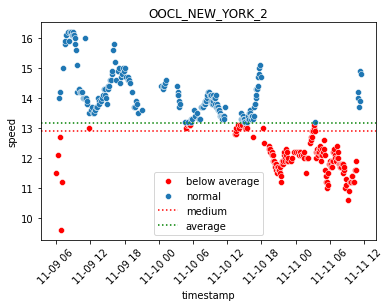

In [28]:
cosco_fos_26 = df
sns.scatterplot(
    data=cosco_fos_26[cosco_fos_26["speed"] < cosco_fos_26["speed"].mean()],
    x='timestamp',
    y='speed',
    color="red",
    label="below average")
sns.scatterplot(
    data=cosco_fos_26[cosco_fos_26["speed"] >= cosco_fos_26["speed"].mean()],
    x='timestamp',
    y='speed',
    label="normal")
plt.title(f"OOCL_NEW_YORK_{voy_num}")
plt.xticks(rotation=45)
# plt.axvline(x=cosco_fos_26["timestamp"].values[0],
#             color="pink",
#             linestyle="dashed",
#             label="dfdf")
# plt.axvline(x=cosco_fos_26["timestamp"].values[-1],
#             color="pink",
#             linestyle="dashed")
# plt.axhline(y=cosco_fos_23["speed"].mean(), linestyle="dotted")
plt.axhline(y=(cosco_fos_26["speed"].max() + cosco_fos_26["speed"].min()) / 2,
            linestyle="dotted",
            label="medium",
            color="red",
            )
plt.axhline(y=cosco_fos_26["speed"].mean(),
            linestyle="dotted",
            label="average",
            color="green",
            )
# use the seaborn violinplot function to visualize the distribution of the speed values
# sns.violinplot(data=cosco_fos_23, x='index', y='speed', inner="stick")
plt.legend()
plt.show()

## 3

In [29]:
df = oocl_nw_3
voy_num = 3

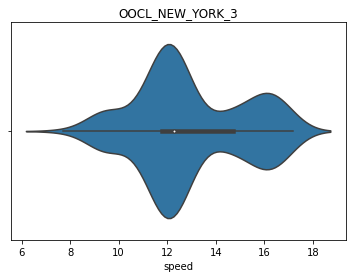

In [30]:
# use the seaborn violinplot function to visualize the distribution of the speed values
sns.violinplot(data=df, x='speed')
plt.title(f"OOCL_NEW_YORK_{voy_num}")

plt.show()

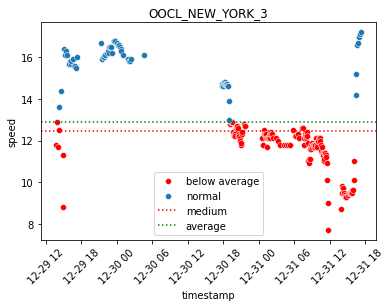

In [31]:
cosco_fos_26 = df
sns.scatterplot(
    data=cosco_fos_26[cosco_fos_26["speed"] < cosco_fos_26["speed"].mean()],
    x='timestamp',
    y='speed',
    color="red",
    label="below average")
sns.scatterplot(
    data=cosco_fos_26[cosco_fos_26["speed"] >= cosco_fos_26["speed"].mean()],
    x='timestamp',
    y='speed',
    label="normal")
plt.title(f"OOCL_NEW_YORK_{voy_num}")
plt.xticks(rotation=45)
# plt.axvline(x=cosco_fos_26["timestamp"].values[0],
#             color="pink",
#             linestyle="dashed",
#             label="dfdf")
# plt.axvline(x=cosco_fos_26["timestamp"].values[-1],
#             color="pink",
#             linestyle="dashed")
# plt.axhline(y=cosco_fos_23["speed"].mean(), linestyle="dotted")
plt.axhline(y=(cosco_fos_26["speed"].max() + cosco_fos_26["speed"].min()) / 2,
            linestyle="dotted",
            label="medium",
            color="red",
            )
plt.axhline(y=cosco_fos_26["speed"].mean(),
            linestyle="dotted",
            label="average",
            color="green",
            )
# use the seaborn violinplot function to visualize the distribution of the speed values
# sns.violinplot(data=cosco_fos_23, x='index', y='speed', inner="stick")
plt.legend()
plt.show()

# ETA 차이 확인

출발지점, 중간 지점, 도착 지점의 ETA 비교   
- proposed_ETA, AIS_ETA, TOS_ETA 비교군,
- ATA는 ATB 고려해서 계산. 2번에서 대기 시간 확인한 것 체크

OOCL_NEW_YORK_1
최대: 4 days 09:58:03.416934
평균: 2 days 08:17:02.714768693


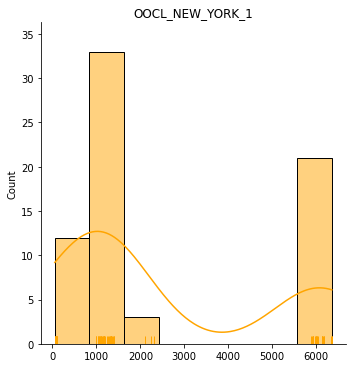

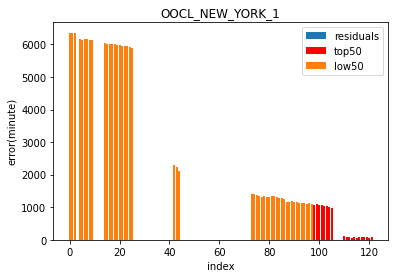

OOCL_NEW_YORK_2
최대: 0 days 02:46:59.237234
평균: 0 days 00:32:21.612489734


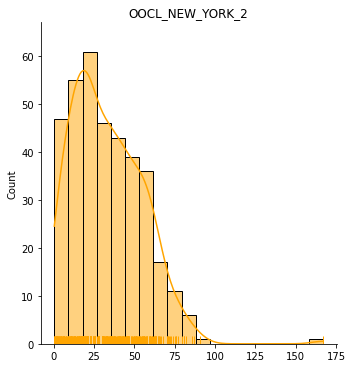

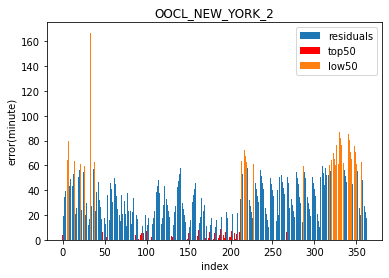

OOCL_NEW_YORK_3
최대: 0 days 03:30:09.999751
평균: 0 days 02:14:03.031423476


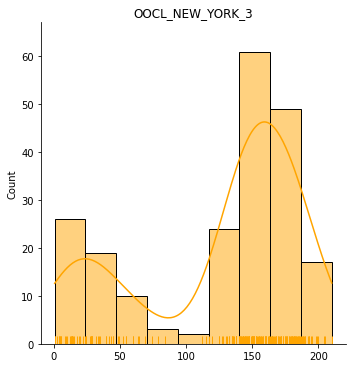

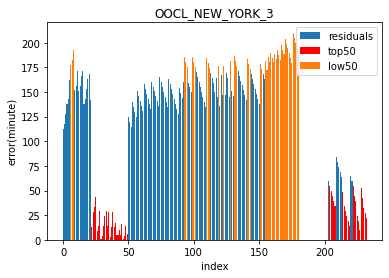

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

result_dfs = [oocl_nw_1, oocl_nw_2,oocl_nw_3] # Replace with actual dataframes
voya_num = [1,2,3]
for i, df in enumerate(result_dfs):
    
    print(f"OOCL_NEW_YORK_{voya_num[i]}")
    print("최대:", df.loc[df.index[:-20]]["error"].max())
    print("평균:", df.loc[df.index[:-20]]["error"].mean())
    sns.displot(df["error"].values.astype(float) / (1e9 * 60), kde=True, rug=True, color="orange")
    plt.title(f"OOCL_NEW_YORK_{voya_num[i]}")
    plt.show()

    error_sorted = df.sort_values('error').dropna()
    high_threshold = error_sorted.iloc[50]["error"]
    low_threshold = error_sorted.iloc[-50]["error"]
    
    high_errors = df[df['error'] < high_threshold]
    low_errors = df[df['error'] > low_threshold]
    plt.bar(df["index"].values, df["error"].values.astype(float) /(1e9 * 60), label="residuals")
    plt.bar(high_errors["index"].values, high_errors["error"].values.astype(float) /(1e9 * 60), label="top50", color="red")
    plt.bar(low_errors["index"].values, low_errors["error"].values.astype(float) /(1e9 * 60), label="low50")
    
    plt.xlabel("index")
    plt.ylabel("error(minute)")
    plt.legend()
    plt.title(f"OOCL_NEW_YORK_{voya_num[i]}")
    plt.show()
    print("="*100)


## 1항차

In [33]:
OONW001_df_eta_index = OONW001_df["ETA"].drop_duplicates().index
OONW001_df.loc[OONW001_df_eta_index,["ETA","timestamp"]]

,ETA,timestamp
0,2022-09-16 16:00:00,2022-09-12 12:23:15.627783
38,2022-09-17 11:00:00,2022-09-13 11:14:14.145458
42,2022-09-20 01:00:00,2022-09-13 14:44:29.161761
44,2022-09-20 16:00:00,2022-09-13 16:14:45.743969
45,2022-09-20 13:00:00,2022-09-13 16:44:34.303285
72,2022-09-19 09:00:00,2022-09-14 11:46:03.671109
162,2022-09-21 13:00:00,2022-09-16 12:04:48.553474
173,2022-09-21 06:00:00,2022-09-16 18:39:39.945974


TOS_ETA
- 출항 전 : 2022-09-19 09:00:00
- 2022-09-16 12:04:48.553474 이후 : 2022-09-21 13:00:00	
- 2022-09-16 18:39:39.945974 이후 : 2022-09-21 06:00:00
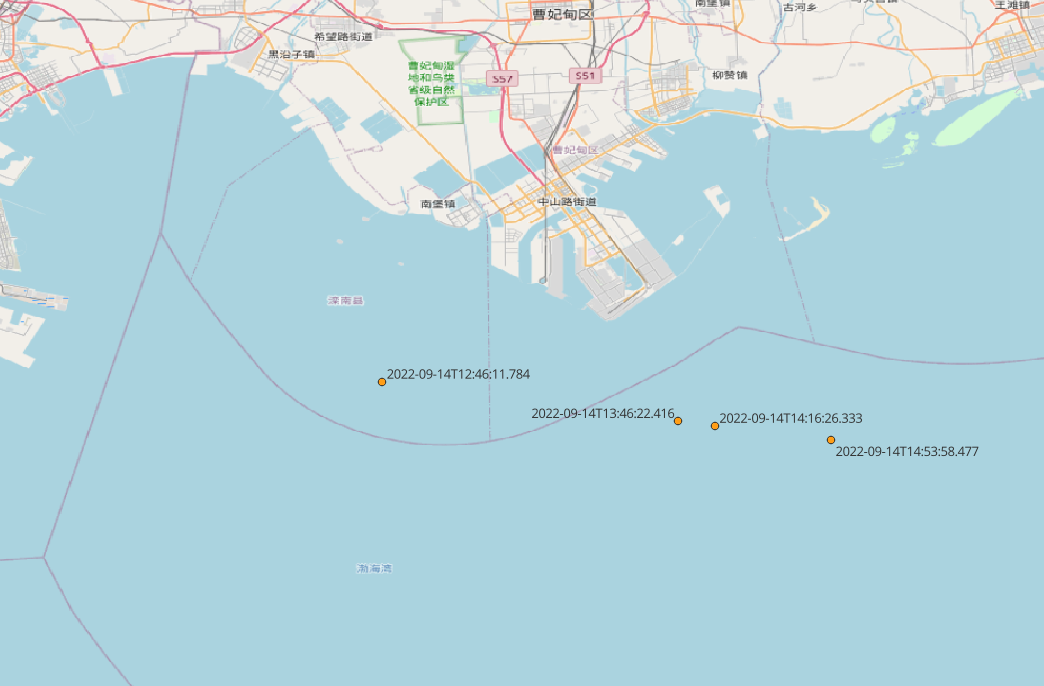
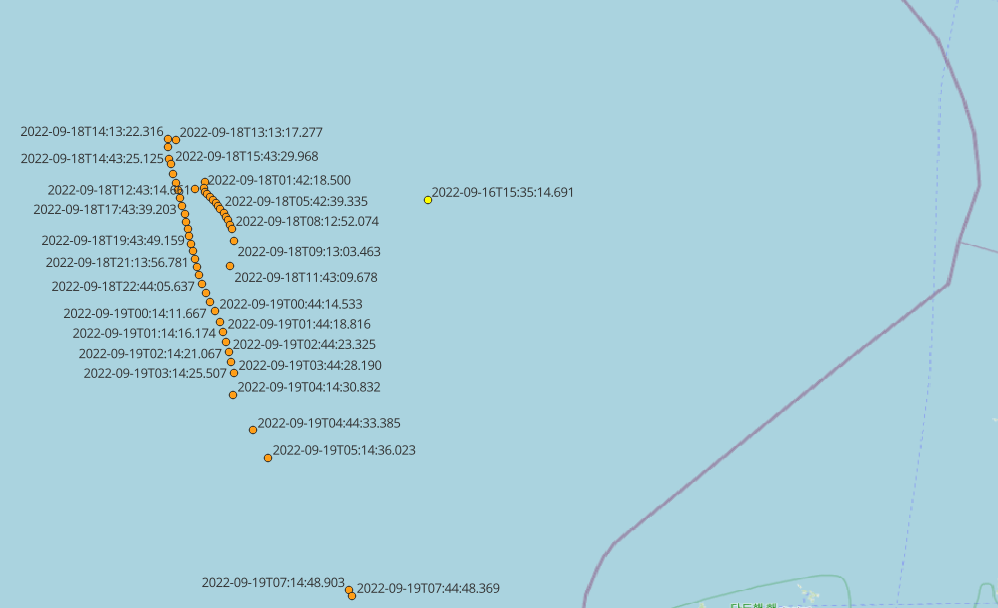
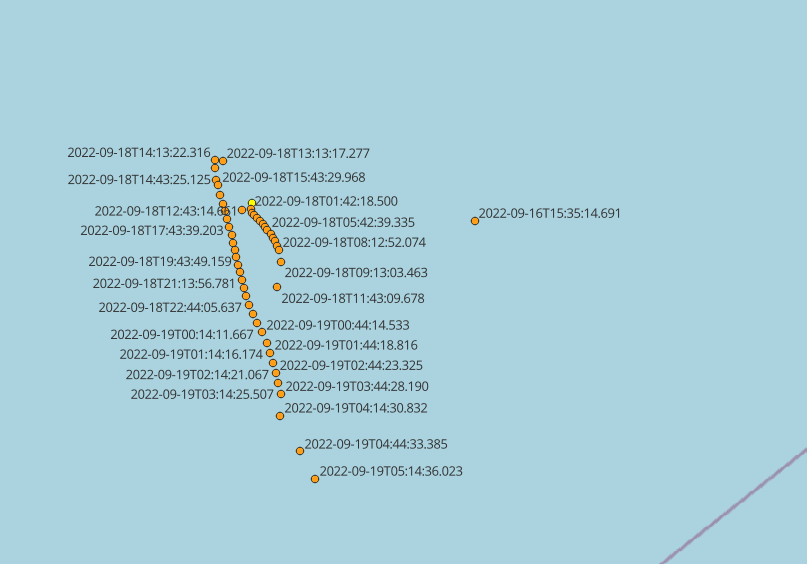

In [34]:
first_idx = oocl_nw_1[oocl_nw_1["timestamp"] < pd.to_datetime('2022-09-16 12:04:48.553474')].index
first_eta = '2022-09-19 09:00:00'

In [35]:
second_idx = oocl_nw_1[
    (oocl_nw_1["timestamp"] > pd.to_datetime('2022-09-16 12:04:48.553474'))
    & (oocl_nw_1["timestamp"] <= pd.to_datetime(
        '2022-09-16 18:39:39.945974'))].index
second_eta = '2022-09-21 13:00:00'

In [36]:
third_idx = oocl_nw_1[oocl_nw_1["timestamp"] >= pd.to_datetime('2022-09-16 18:39:39.945974')].index
third_eta = '2022-09-21 06:00:00'

In [37]:
oocl_nw_1.loc[first_idx,"TOS_ETA"] = first_eta
oocl_nw_1.loc[second_idx,"TOS_ETA"] = second_eta
oocl_nw_1.loc[third_idx,"TOS_ETA"] = third_eta


- ATB : 2022-09-21 06:20:00

In [38]:
pnit_history = pd.read_excel("pnit_berth_history_2.xlsx")
pnit_history[pnit_history["모선항차"] == "OONW001"]

,선석,선사,모선항차,선사항차,Head (Bridge) Stern,선명,ROUTE,반입마감시한,접안(예정)일시,출항(예정)일시,양하,적하,Shift,상태
135,T3(P),OOL,OONW001,089W/089W,43 (54) 60,OOCL NEW YORK,CIX3,2022-09-20 21:00:00,2022-09-21 06:20:00,2022-09-21 16:40:00,764,241,16,DEPARTED


In [39]:
oocl_nw_1["PNIT_ETB"] = '2022-09-21 06:20:00'

In [40]:
oocl_nw_1["PNIT_ETB"] = pd.to_datetime(oocl_nw_1["PNIT_ETB"])
oocl_nw_1["TOS_ETA"] = pd.to_datetime(oocl_nw_1["TOS_ETA"])
oocl_nw_1["waiting_time"] = abs(oocl_nw_1["PNIT_ETB"] - oocl_nw_1["ATA"] )
oocl_nw_1["ais_eta_error"] = abs(oocl_nw_1["ais_eta"] - oocl_nw_1["ATA"] )
oocl_nw_1["TOS_ETA_error"] = abs(oocl_nw_1["TOS_ETA"] - oocl_nw_1["ATA"] )

In [41]:
start_time = oocl_nw_1.loc[oocl_nw_1.index[0], "timestamp"]
end_time =oocl_nw_1.loc[oocl_nw_1.index[-1], "timestamp"]
middle_time = start_time + (end_time - start_time) / 2
oocl_nw_1['diff'] = abs(oocl_nw_1['timestamp'] - middle_time)
closest_index = oocl_nw_1['diff'].idxmin()

# Get the closest timestamp
closest_timestamp = oocl_nw_1.loc[closest_index, 'timestamp']

In [42]:
oocl_nw_1.drop(columns=["diff","eta",'mmsi','imo','CAPACITY'], inplace=True)

In [43]:
oocl_nw_1["ais_eta_error"].value_counts()

0 days 19:22:27.234942    39
1 days 16:21:27.234942    21
0 days 20:22:27.234942     6
8 days 18:22:27.234942     3
Name: ais_eta_error, dtype: int64

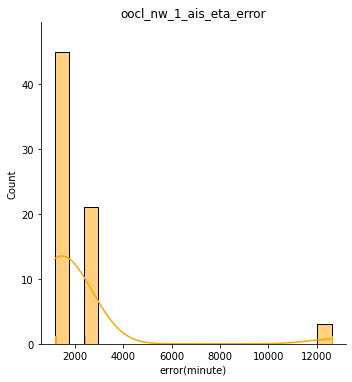

In [44]:
sns.displot(oocl_nw_1["ais_eta_error"].values.astype(float) / (1e9 * 60), kde=True, rug=True, color="orange")
plt.xlabel("error(minute)")
plt.title(f"oocl_nw_1_ais_eta_error")# sns.violinplot(data=cosco_fos_23, x='ais_eta_error_numeric')

plt.show()

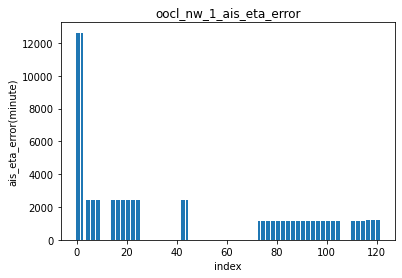

In [45]:
plt.bar(oocl_nw_1["index"].values, oocl_nw_1["ais_eta_error"].values.astype(float) /(1e9 * 60))
# sns.barplot(data=cosco_fos_23, x="index", y='ais_eta_error_numeric')

plt.xlabel("index")
plt.ylabel("ais_eta_error(minute)")
plt.yticks()
plt.title(f"oocl_nw_1_ais_eta_error")
plt.show()

In [46]:
oocl_nw_1["TOS_ETA_error"].value_counts()

0 days 01:37:32.765058    48
1 days 19:22:27.234942    21
Name: TOS_ETA_error, dtype: int64

In [47]:
cosco_fos_23 = oocl_nw_1

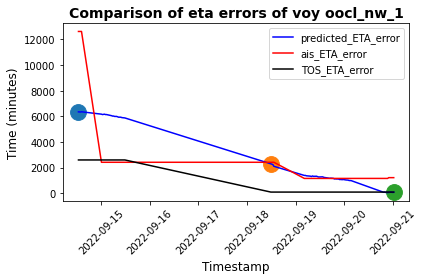

In [48]:
cosco_fos_23['error_minutes'] = cosco_fos_23['error'].dt.total_seconds() / 60
cosco_fos_23['ais_eta_error_minutes'] = cosco_fos_23['ais_eta_error'].dt.total_seconds() / 60
cosco_fos_23['TOS_ETA_error_minutes'] = cosco_fos_23['TOS_ETA_error'].dt.total_seconds() / 60

# plot the comparison using seaborn lineplot
sns.lineplot(data=cosco_fos_23, x="timestamp", y='error_minutes', color='blue', label="predicted_ETA_error")
sns.lineplot(data=cosco_fos_23, x="timestamp", y='ais_eta_error_minutes', color='red', label="ais_ETA_error")
sns.lineplot(data=cosco_fos_23, x="timestamp", y='TOS_ETA_error_minutes', color='black', label="TOS_ETA_error")

# plt.axvline(x=cosco_fos_23.timestamp[0],ymax=0.9,ymin=0.1,
#             linestyle="dotted",
#             label="medium",
#             color="red",
#             )

plt.scatter(x=cosco_fos_23.timestamp[0], y=cosco_fos_23.error_minutes[0], s=250)
# plt.scatter(x=cosco_fos_23.timestamp[0], y=cosco_fos_23.ais_eta_error_minutes[0])
# plt.scatter(x=cosco_fos_23.timestamp[0], y=cosco_fos_23.TOS_ETA_error_minutes[0])
plt.scatter(x=cosco_fos_23.timestamp[closest_index], y=cosco_fos_23.error_minutes[closest_index], s=250)
# plt.scatter(x=cosco_fos_23.timestamp[closest_index], y=cosco_fos_23.ais_eta_error_minutes[closest_index])
# plt.scatter(x=cosco_fos_23.timestamp[closest_index], y=cosco_fos_23.TOS_ETA_error_minutes[closest_index])
plt.scatter(x=cosco_fos_23.timestamp[cosco_fos_23.index[-1]], y=cosco_fos_23.error_minutes[cosco_fos_23.index[-1]], s=250)
# plt.scatter(x=cosco_fos_23.timestamp[cosco_fos_23.index[-1]], y=cosco_fos_23.ais_eta_error_minutes[cosco_fos_23.index[-1]])
# plt.scatter(x=cosco_fos_23.timestamp[cosco_fos_23.index[-1]], y=cosco_fos_23.TOS_ETA_error_minutes[cosco_fos_23.index[-1]])

# customize the plot to make it visually appealing
plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Time (minutes)', fontsize=12)
plt.title('Comparison of eta errors of voy oocl_nw_1', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [49]:
cosco_fos_23.loc[[cosco_fos_23.index[0],closest_index,cosco_fos_23.index[-1]],['vessel_name','timestamp','ETA','ATA','waiting_time','error','ais_eta','TOS_ETA','PNIT_ETB','ais_eta_error','TOS_ETA_error']]

,vessel_name,timestamp,ETA,ATA,waiting_time,error,ais_eta,TOS_ETA,PNIT_ETB,ais_eta_error,TOS_ETA_error
0,OOCL NEW YORK,2022-09-14 12:46:11.783705,2022-09-16 18:27:51.145111,2022-09-21 04:22:27.234942,0 days 01:57:32.765058,4 days 09:54:36.089831,2022-09-12 10:00:00,2022-09-19 09:00:00,2022-09-21 06:20:00,8 days 18:22:27.234942,1 days 19:22:27.234942
21,OOCL NEW YORK,2022-09-18 11:43:09.677603,2022-09-19 14:01:38.015909,2022-09-21 04:22:27.234942,0 days 01:57:32.765058,1 days 14:20:49.219033,2022-09-19 12:01:00,2022-09-21 06:00:00,2022-09-21 06:20:00,1 days 16:21:27.234942,0 days 01:37:32.765058
68,OOCL NEW YORK,2022-09-21 00:22:07.243076,2022-09-21 02:53:40.347937,2022-09-21 04:22:27.234942,0 days 01:57:32.765058,0 days 01:28:46.887005,2022-09-20 08:00:00,2022-09-21 06:00:00,2022-09-21 06:20:00,0 days 20:22:27.234942,0 days 01:37:32.765058


In [50]:
type(waiting_list)

list

In [51]:
voyage_list.append(1)
waiting_list.append(cosco_fos_23.loc[0,"waiting_time"])

## 2항차

In [52]:
OONW002_df_eta_index = OONW002_df["ETA"].drop_duplicates().index
OONW002_df.loc[OONW002_df_eta_index,["ETA","timestamp"]]

,ETA,timestamp
0,2022-11-11 16:00:00,2022-10-29 00:01:26.679224
2583,2022-11-11 13:00:00,2022-11-08 11:06:40.174778


TOS_ETA
- 출항 전 : 2022-11-11 13:00:00
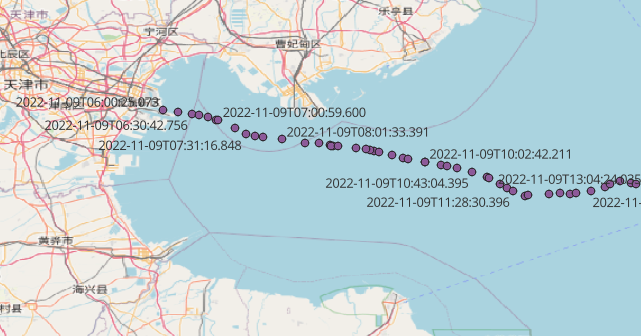

In [53]:
# first_idx = oocl_nw_1[oocl_nw_1["timestamp"] < pd.to_datetime('2022-09-16 12:04:48.553474')].index
# first_eta = '2022-09-19 09:00:00'

In [54]:
# second_idx = oocl_nw_1[
#     (oocl_nw_1["timestamp"] > pd.to_datetime('2022-09-16 12:04:48.553474'))
#     & (oocl_nw_1["timestamp"] <= pd.to_datetime(
#         '2022-09-16 18:39:39.945974'))].index
# second_eta = '2022-09-21 13:00:00'

In [55]:
# third_idx = oocl_nw_1[oocl_nw_1["timestamp"] >= pd.to_datetime('2022-09-16 18:39:39.945974')].index
# third_eta = '2022-09-21 06:00:00'

In [56]:
# oocl_nw_1.loc[first_idx,"TOS_ETA"] = first_eta
# oocl_nw_1.loc[second_idx,"TOS_ETA"] = second_eta
# oocl_nw_1.loc[third_idx,"TOS_ETA"] = third_eta


In [57]:
oocl_nw_2["TOS_ETA"] = '2022-11-11 13:00:00'

- ATB : 2022-11-11 14:25:00

In [58]:
pnit_history = pd.read_excel("pnit_berth_history_2.xlsx")
pnit_history[pnit_history["모선항차"] == "OONW002"]['접안(예정)일시'].values[0]

numpy.datetime64('2022-11-11T14:25:00.000000000')

In [59]:
oocl_nw_2["PNIT_ETB"] = pnit_history[pnit_history["모선항차"] == "OONW002"]['접안(예정)일시'].values[0]

In [60]:
oocl_nw_2["PNIT_ETB"] = pd.to_datetime(oocl_nw_2["PNIT_ETB"])
oocl_nw_2["TOS_ETA"] = pd.to_datetime(oocl_nw_2["TOS_ETA"])
oocl_nw_2["waiting_time"] = abs(oocl_nw_2["PNIT_ETB"] - oocl_nw_2["ATA"] )
oocl_nw_2["ais_eta_error"] = abs(oocl_nw_2["ais_eta"] - oocl_nw_2["ATA"] )
oocl_nw_2["TOS_ETA_error"] = abs(oocl_nw_2["TOS_ETA"] - oocl_nw_2["ATA"] )

In [61]:
start_time = oocl_nw_2.loc[oocl_nw_2.index[0], "timestamp"]
end_time =oocl_nw_2.loc[oocl_nw_2.index[-1], "timestamp"]
middle_time = start_time + (end_time - start_time) / 2
oocl_nw_2['diff'] = abs(oocl_nw_2['timestamp'] - middle_time)
closest_index = oocl_nw_2['diff'].idxmin()

# Get the closest timestamp
closest_timestamp = oocl_nw_2.loc[closest_index, 'timestamp']

In [62]:
oocl_nw_2.drop(columns=["diff","eta",'mmsi','imo','CAPACITY'], inplace=True)

In [63]:
oocl_nw_2["ais_eta_error"].value_counts()

0 days 10:29:16.869978    288
0 days 08:29:16.869978     38
0 days 08:59:16.869978     23
0 days 08:44:16.869978     10
0 days 07:59:16.869978      4
Name: ais_eta_error, dtype: int64

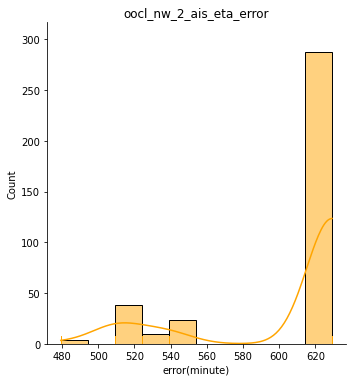

In [64]:
sns.displot(oocl_nw_2["ais_eta_error"].values.astype(float) / (1e9 * 60), kde=True, rug=True, color="orange")
plt.xlabel("error(minute)")
plt.title(f"oocl_nw_2_ais_eta_error")# sns.violinplot(data=cosco_fos_23, x='ais_eta_error_numeric')

plt.show()

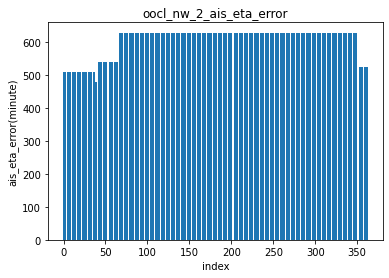

In [65]:
plt.bar(oocl_nw_2["index"].values, oocl_nw_2["ais_eta_error"].values.astype(float) /(1e9 * 60))
# sns.barplot(data=cosco_fos_23, x="index", y='ais_eta_error_numeric')

plt.xlabel("index")
plt.ylabel("ais_eta_error(minute)")
plt.yticks()
plt.title(f"oocl_nw_2_ais_eta_error")
plt.show()

In [66]:
oocl_nw_2["TOS_ETA_error"].value_counts()

0 days 00:30:43.130022    363
Name: TOS_ETA_error, dtype: int64

In [67]:
cosco_fos_23 = oocl_nw_2

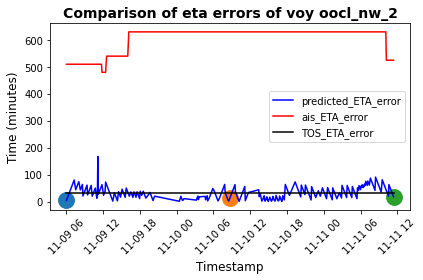

In [68]:
cosco_fos_23['error_minutes'] = cosco_fos_23['error'].dt.total_seconds() / 60
cosco_fos_23['ais_eta_error_minutes'] = cosco_fos_23['ais_eta_error'].dt.total_seconds() / 60
cosco_fos_23['TOS_ETA_error_minutes'] = cosco_fos_23['TOS_ETA_error'].dt.total_seconds() / 60

# plot the comparison using seaborn lineplot
sns.lineplot(data=cosco_fos_23, x="timestamp", y='error_minutes', color='blue', label="predicted_ETA_error")
sns.lineplot(data=cosco_fos_23, x="timestamp", y='ais_eta_error_minutes', color='red', label="ais_ETA_error")
sns.lineplot(data=cosco_fos_23, x="timestamp", y='TOS_ETA_error_minutes', color='black', label="TOS_ETA_error")

# plt.axvline(x=cosco_fos_23.timestamp[0],ymax=0.9,ymin=0.1,
#             linestyle="dotted",
#             label="medium",
#             color="red",
#             )

plt.scatter(x=cosco_fos_23.timestamp[0], y=cosco_fos_23.error_minutes[0], s=250)
# plt.scatter(x=cosco_fos_23.timestamp[0], y=cosco_fos_23.ais_eta_error_minutes[0])
# plt.scatter(x=cosco_fos_23.timestamp[0], y=cosco_fos_23.TOS_ETA_error_minutes[0])
plt.scatter(x=cosco_fos_23.timestamp[closest_index], y=cosco_fos_23.error_minutes[closest_index], s=250)
# plt.scatter(x=cosco_fos_23.timestamp[closest_index], y=cosco_fos_23.ais_eta_error_minutes[closest_index])
# plt.scatter(x=cosco_fos_23.timestamp[closest_index], y=cosco_fos_23.TOS_ETA_error_minutes[closest_index])
plt.scatter(x=cosco_fos_23.timestamp[cosco_fos_23.index[-1]], y=cosco_fos_23.error_minutes[cosco_fos_23.index[-1]], s=250)
# plt.scatter(x=cosco_fos_23.timestamp[cosco_fos_23.index[-1]], y=cosco_fos_23.ais_eta_error_minutes[cosco_fos_23.index[-1]])
# plt.scatter(x=cosco_fos_23.timestamp[cosco_fos_23.index[-1]], y=cosco_fos_23.TOS_ETA_error_minutes[cosco_fos_23.index[-1]])

# customize the plot to make it visually appealing
plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Time (minutes)', fontsize=12)
plt.title('Comparison of eta errors of voy oocl_nw_2', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [69]:
cosco_fos_23.loc[[cosco_fos_23.index[0],closest_index,cosco_fos_23.index[-1]],['vessel_name','timestamp','ETA','ATA','waiting_time','error','ais_eta','TOS_ETA','PNIT_ETB','ais_eta_error','TOS_ETA_error']]

,vessel_name,timestamp,ETA,ATA,waiting_time,error,ais_eta,TOS_ETA,PNIT_ETB,ais_eta_error,TOS_ETA_error
0,OOCL NEW YORK,2022-11-09 06:00:25.073144,2022-11-11 12:33:10.404025,2022-11-11 12:29:16.869978,0 days 01:55:43.130022,0 days 00:03:53.534047,2022-11-11 04:00:00,2022-11-11 13:00:00,2022-11-11 14:25:00,0 days 08:29:16.869978,0 days 00:30:43.130022
132,OOCL NEW YORK,2022-11-10 08:40:26.092225,2022-11-11 12:41:34.369705,2022-11-11 12:29:16.869978,0 days 01:55:43.130022,0 days 00:12:17.499727,2022-11-11 02:00:00,2022-11-11 13:00:00,2022-11-11 14:25:00,0 days 10:29:16.869978,0 days 00:30:43.130022
362,OOCL NEW YORK,2022-11-11 11:23:40.010251,2022-11-11 12:11:43.326434,2022-11-11 12:29:16.869978,0 days 01:55:43.130022,0 days 00:17:33.543544,2022-11-11 03:45:00,2022-11-11 13:00:00,2022-11-11 14:25:00,0 days 08:44:16.869978,0 days 00:30:43.130022


In [70]:
voyage_list.append(2)
waiting_list.append(cosco_fos_23.loc[0,"waiting_time"])

## 3항차

In [71]:
OONW003_df_eta_index = OONW003_df["ETA"].drop_duplicates().index
OONW003_df.loc[OONW003_df_eta_index,["ETA","timestamp"]]

,ETA,timestamp
0,2022-11-04 16:00:00,2022-11-01 17:36:50.501338
906,2022-12-30 16:00:00,2022-11-21 16:49:56.710003
9265,2022-12-30 21:00:00,2022-12-22 18:47:04.168496
9471,2022-12-31 21:00:00,2022-12-23 11:59:41.083802
10314,2022-12-31 11:00:00,2022-12-26 10:48:43.524681
10878,2022-12-31 04:00:00,2022-12-28 10:10:59.139973
10884,2022-12-31 10:00:00,2022-12-28 10:41:03.137032
10931,2022-12-31 17:00:00,2022-12-28 15:30:34.275817
11729,2022-12-31 20:00:00,2022-12-31 11:03:10.373432
11789,2022-12-31 19:00:00,2022-12-31 16:03:56.409491


TOS_ETA
- 출항 전 : 2022-12-31 17:00:00
- 2022-12-31 11:03:10.373432 이후 : 2022-12-31 20:00:00	
- 2022-12-31 16:03:56.409491 이후 : 2022-12-31 19:00:00
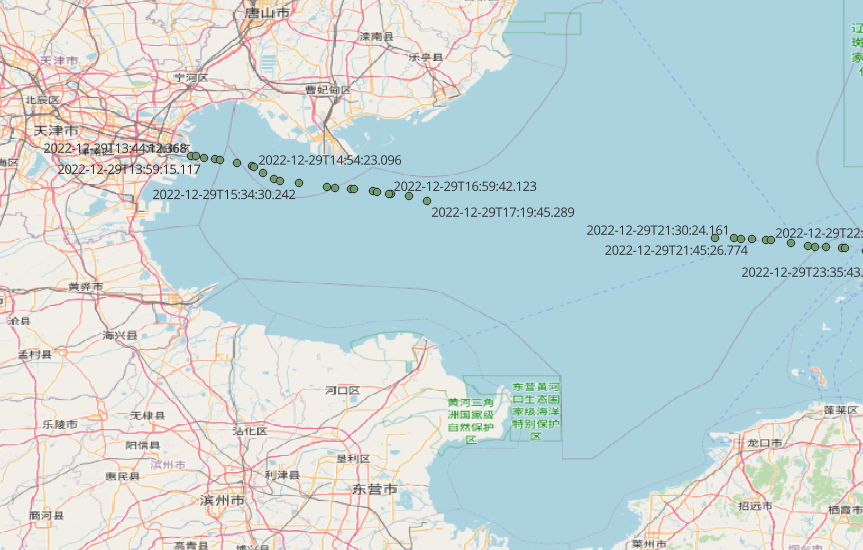
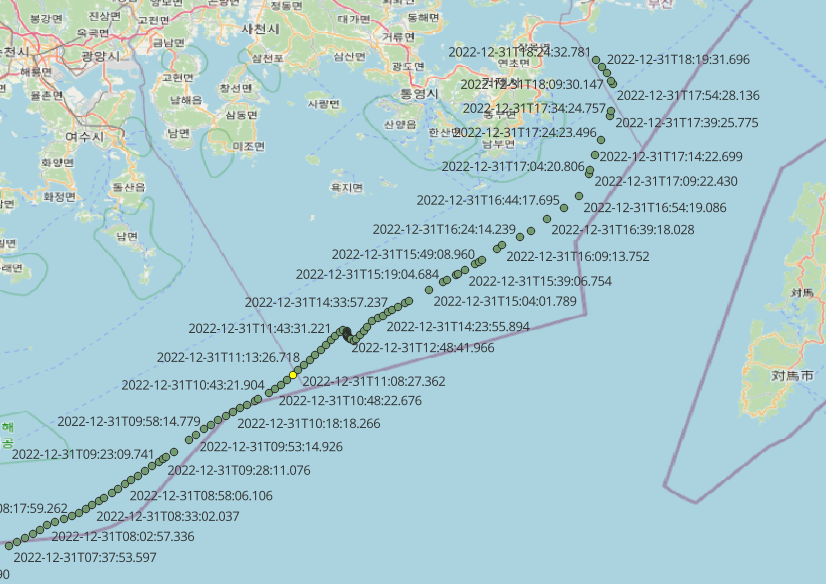
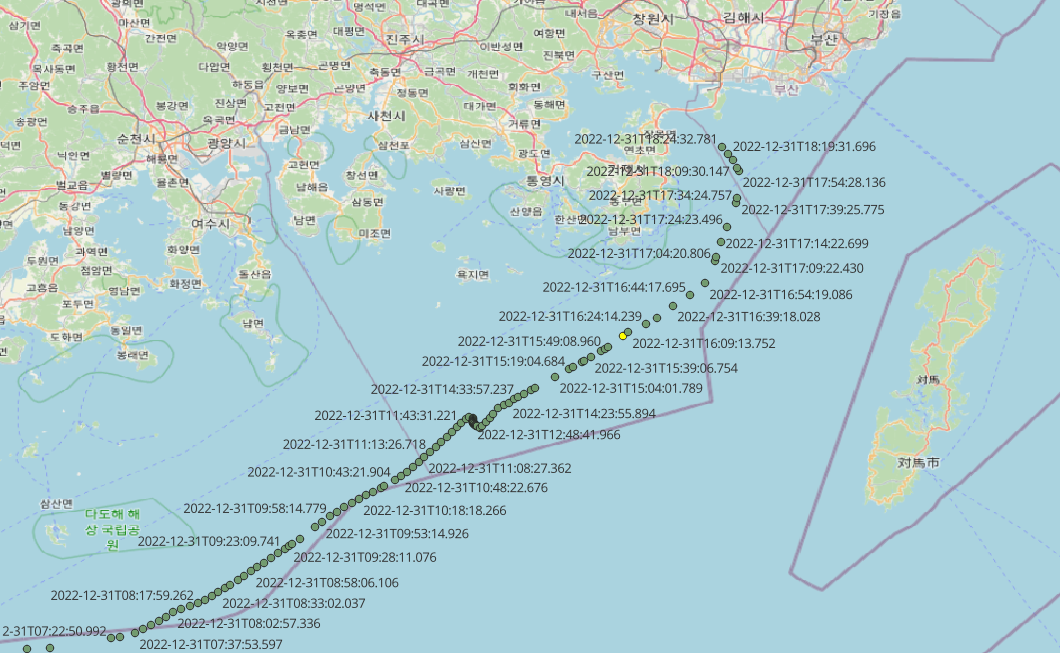

In [72]:
first_idx = oocl_nw_3[oocl_nw_3["timestamp"] <= pd.to_datetime('2022-12-31 11:03:10.373432')].index
first_eta = '2022-12-31 17:00:00'

In [73]:
second_idx = oocl_nw_3[
    (oocl_nw_3["timestamp"] > pd.to_datetime('2022-12-31 11:03:10.373432'))
    & (oocl_nw_3["timestamp"] <= pd.to_datetime(
        '2022-12-31 16:03:56.409491'))].index
second_eta = '2022-12-31 20:00:00'

In [74]:
third_idx = oocl_nw_3[oocl_nw_3["timestamp"] >= pd.to_datetime('2022-12-31 16:03:56.409491')].index
third_eta = '2022-12-31 19:00:00'

In [75]:
oocl_nw_3.loc[first_idx,"TOS_ETA"] = first_eta
oocl_nw_3.loc[second_idx,"TOS_ETA"] = second_eta
oocl_nw_3.loc[third_idx,"TOS_ETA"] = third_eta


- ATB : 2022-11-11 14:25:00

In [76]:
pnit_history = pd.read_excel("pnit_berth_history_2.xlsx")
pnit_history[pnit_history["모선항차"] == "OONW003"]['접안(예정)일시'].values[0]

numpy.datetime64('2022-12-31T19:50:00.000000000')

In [77]:
oocl_nw_3["PNIT_ETB"] = pnit_history[pnit_history["모선항차"] == "OONW003"]['접안(예정)일시'].values[0]

In [78]:
oocl_nw_3["PNIT_ETB"] = pd.to_datetime(oocl_nw_3["PNIT_ETB"])
oocl_nw_3["TOS_ETA"] = pd.to_datetime(oocl_nw_3["TOS_ETA"])
oocl_nw_3["waiting_time"] = abs(oocl_nw_3["PNIT_ETB"] - oocl_nw_3["ATA"] )
oocl_nw_3["ais_eta_error"] = abs(oocl_nw_3["ais_eta"] - oocl_nw_3["ATA"] )
oocl_nw_3["TOS_ETA_error"] = abs(oocl_nw_3["TOS_ETA"] - oocl_nw_3["ATA"] )

In [79]:
start_time = oocl_nw_3.loc[oocl_nw_3.index[0], "timestamp"]
end_time =oocl_nw_3.loc[oocl_nw_3.index[-1], "timestamp"]
middle_time = start_time + (end_time - start_time) / 2
oocl_nw_3['diff'] = abs(oocl_nw_3['timestamp'] - middle_time)
closest_index = oocl_nw_3['diff'].idxmin()

# Get the closest timestamp
closest_timestamp = oocl_nw_3.loc[closest_index, 'timestamp']

In [80]:
oocl_nw_3.drop(columns=["diff","eta",'mmsi','imo','CAPACITY'], inplace=True)

In [81]:
oocl_nw_3["ais_eta_error"].value_counts()

0 days 10:24:32.781137    181
0 days 07:24:32.781137     14
0 days 07:34:32.781137      9
0 days 08:39:32.781137      7
Name: ais_eta_error, dtype: int64

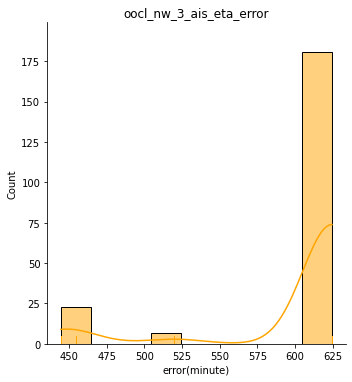

In [82]:
sns.displot(oocl_nw_3["ais_eta_error"].values.astype(float) / (1e9 * 60), kde=True, rug=True, color="orange")
plt.xlabel("error(minute)")
plt.title(f"oocl_nw_3_ais_eta_error")# sns.violinplot(data=cosco_fos_23, x='ais_eta_error_numeric')

plt.show()

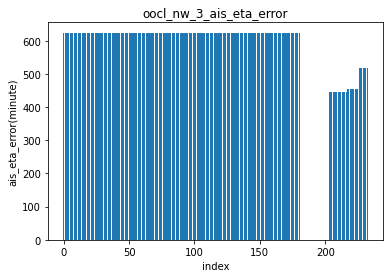

In [83]:
plt.bar(oocl_nw_3["index"].values, oocl_nw_3["ais_eta_error"].values.astype(float) /(1e9 * 60))
# sns.barplot(data=cosco_fos_23, x="index", y='ais_eta_error_numeric')

plt.xlabel("index")
plt.ylabel("ais_eta_error(minute)")
plt.yticks()
plt.title(f"oocl_nw_3_ais_eta_error")
plt.show()

In [84]:
oocl_nw_3["TOS_ETA_error"].value_counts()

0 days 01:24:32.781137    171
0 days 01:35:27.218863     30
0 days 00:35:27.218863     10
Name: TOS_ETA_error, dtype: int64

In [85]:
cosco_fos_23 = oocl_nw_3

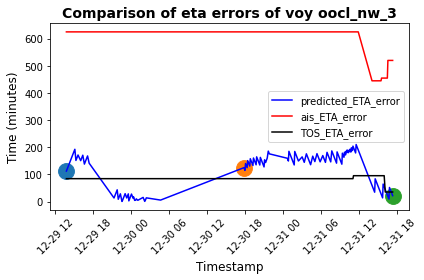

In [86]:
cosco_fos_23['error_minutes'] = cosco_fos_23['error'].dt.total_seconds() / 60
cosco_fos_23['ais_eta_error_minutes'] = cosco_fos_23['ais_eta_error'].dt.total_seconds() / 60
cosco_fos_23['TOS_ETA_error_minutes'] = cosco_fos_23['TOS_ETA_error'].dt.total_seconds() / 60

# plot the comparison using seaborn lineplot
sns.lineplot(data=cosco_fos_23, x="timestamp", y='error_minutes', color='blue', label="predicted_ETA_error")
sns.lineplot(data=cosco_fos_23, x="timestamp", y='ais_eta_error_minutes', color='red', label="ais_ETA_error")
sns.lineplot(data=cosco_fos_23, x="timestamp", y='TOS_ETA_error_minutes', color='black', label="TOS_ETA_error")

# plt.axvline(x=cosco_fos_23.timestamp[0],ymax=0.9,ymin=0.1,
#             linestyle="dotted",
#             label="medium",
#             color="red",
#             )

plt.scatter(x=cosco_fos_23.timestamp[0], y=cosco_fos_23.error_minutes[0], s=250)
# plt.scatter(x=cosco_fos_23.timestamp[0], y=cosco_fos_23.ais_eta_error_minutes[0])
# plt.scatter(x=cosco_fos_23.timestamp[0], y=cosco_fos_23.TOS_ETA_error_minutes[0])
plt.scatter(x=cosco_fos_23.timestamp[closest_index], y=cosco_fos_23.error_minutes[closest_index], s=250)
# plt.scatter(x=cosco_fos_23.timestamp[closest_index], y=cosco_fos_23.ais_eta_error_minutes[closest_index])
# plt.scatter(x=cosco_fos_23.timestamp[closest_index], y=cosco_fos_23.TOS_ETA_error_minutes[closest_index])
plt.scatter(x=cosco_fos_23.timestamp[cosco_fos_23.index[-1]], y=cosco_fos_23.error_minutes[cosco_fos_23.index[-1]], s=250)
# plt.scatter(x=cosco_fos_23.timestamp[cosco_fos_23.index[-1]], y=cosco_fos_23.ais_eta_error_minutes[cosco_fos_23.index[-1]])
# plt.scatter(x=cosco_fos_23.timestamp[cosco_fos_23.index[-1]], y=cosco_fos_23.TOS_ETA_error_minutes[cosco_fos_23.index[-1]])

# customize the plot to make it visually appealing
plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Time (minutes)', fontsize=12)
plt.title('Comparison of eta errors of voy oocl_nw_3', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [87]:
cosco_fos_23.loc[[cosco_fos_23.index[0],closest_index,cosco_fos_23.index[-1]],['vessel_name','timestamp','ETA','ATA','waiting_time','error','ais_eta','TOS_ETA','PNIT_ETB','ais_eta_error','TOS_ETA_error']]

,vessel_name,timestamp,ETA,ATA,waiting_time,error,ais_eta,TOS_ETA,PNIT_ETB,ais_eta_error,TOS_ETA_error
0,OOCL NEW YORK,2022-12-29 13:44:12.367784,2022-12-31 20:16:57.698665,2022-12-31 18:24:32.781137,0 days 01:25:27.218863,0 days 01:52:24.917528,2022-12-31 08:00:00,2022-12-31 17:00:00,2022-12-31 19:50:00,0 days 10:24:32.781137,0 days 01:24:32.781137
50,OOCL NEW YORK,2022-12-30 17:45:46.454663,2022-12-31 16:19:34.657953,2022-12-31 18:24:32.781137,0 days 01:25:27.218863,0 days 02:04:58.123184,2022-12-31 08:00:00,2022-12-31 17:00:00,2022-12-31 19:50:00,0 days 10:24:32.781137,0 days 01:24:32.781137
210,OOCL NEW YORK,2022-12-31 17:14:22.699183,2022-12-31 18:02:26.015366,2022-12-31 18:24:32.781137,0 days 01:25:27.218863,0 days 00:22:06.765771,2022-12-31 09:45:00,2022-12-31 19:00:00,2022-12-31 19:50:00,0 days 08:39:32.781137,0 days 00:35:27.218863


In [88]:
voyage_list.append(3)
waiting_list.append(cosco_fos_23.loc[0,"waiting_time"])

# waiting time

In [89]:
waiting_list = pd.to_timedelta(waiting_list)

In [90]:
voyage_list.append("avg")
waiting_list = waiting_list.values.astype(float) / (1e9 * 60)

In [91]:
waiting_list = np.append(waiting_list, np.mean(waiting_list))

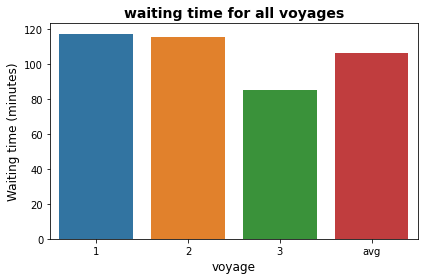

In [92]:
sns.barplot(x=voyage_list, y=waiting_list)
plt.xlabel('voyage', fontsize=12)
plt.ylabel('Waiting time (minutes)', fontsize=12)
plt.title('waiting time for all voyages', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()